# Nuclear Statistical Equilibrium

Pynucastro is able to calculate the abundances at nuclear statistical equilibrium of a given reaction network by solving NSE equations using scipy.fsolve(). (see https://iopscience.iop.org/article/10.1086/510709/pdf and https://www.sciencedirect.com/science/article/abs/pii/S0092640X0800051X).

This notebook gives an illustration of this feature.

In [1]:
import pynucastro as pyna
import numpy as np
import matplotlib.pyplot as plt

We start by creating a `Library` object that reads all the ReacLib rates and link different nuclei of choice. Then initialize `RateCollection` by using the the rates created by the `Library` object.

In [2]:
library = pyna.ReacLibLibrary()

subch_full = library.linking_nuclei(["p","he4","c12","n13","n14","o16","f18","ne20",
                                      "ne21","na22","na23","mg24","al27","si28","p31","s32",
                                     "cl35","ar36","k39","ca40","sc43","ti44","v47","cr48","mn51",
                                     "fe52","co55","ni56"])

rc = pyna.RateCollection(libraries=subch_full)

`get_comp_nse(rho,T,ye)` is a method of `RateCollection` that returns composition at NSE as an object `Composition` by providing density, temperature, and a presribed electron fraction. There is pre-set initial guess, however one should adjust the initial guess, accordingly if no solutions are found or taking a long time as the algorithm is searching for the correct initial guess.

It has options of incorporating coulomb correction terms by let `use_coulomb_corr=True`, and return the solution of proton and neutron chemical potentials by `return_sol=True`.

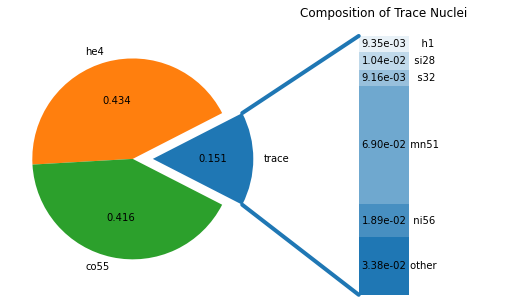

  X(p) : 0.009350257557755745
  X(he4) : 0.4336432648337397
  X(c12) : 7.728730855863679e-06
  X(n13) : 2.592044572072426e-10
  X(n14) : 1.366332980043754e-09
  X(o16) : 1.5697551606923965e-05
  X(f18) : 2.411406340623987e-11
  X(ne20) : 3.018748620023282e-07
  X(ne21) : 3.956328637888796e-09
  X(na22) : 9.687083066114455e-10
  X(na23) : 7.296922766617077e-08
  X(mg24) : 3.4701773454356374e-05
  X(al27) : 3.3526418310423996e-05
  X(si28) : 0.01043957131530905
  X(p31) : 0.00213499350058423
  X(s32) : 0.009160645411758385
  X(cl35) : 0.004000874822061756
  X(ar36) : 0.004879636200528169
  X(k39) : 0.005552717409027393
  X(ca40) : 0.0047698633574799545
  X(sc43) : 0.0003726846903449166
  X(ti44) : 0.00022925810669629146
  X(v47) : 0.004900622959185997
  X(cr48) : 0.0011488659730385128
  X(mn51) : 0.06904761336409458
  X(fe52) : 0.00574686874545434
  X(co55) : 0.41561537762309186
  X(ni56) : 0.018914848236755235

After solving, the chemical potential for proton and neutron are -7.73861021

In [3]:
comp, sol = rc.get_comp_nse(1e7, 6e9, 0.50, use_coulomb_corr=True, return_sol=True)
comp.plot()
print(comp)
print(f"After solving, the chemical potential for proton and neutron are {sol[0]} and {sol[1]}")

For $\rho = 1\times 10^7 [g/cm^{3}]$ and electron fraction, $Y_e = 0.5$

In [4]:
rho = 1e7
ye = 0.5
temps = np.linspace(2.5, 12.0, 100)
X_s = []

guess = [-6.0, -11.5]
for i, temp in enumerate(temps):
    nse_comp, sol = rc.get_comp_nse(rho, temp*1.0e9, ye, init_guess=guess, 
                                    use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s = [nse_comp.X[nuc] for nuc in nse_comp.X]
    X_s.append(nse_X_s)

Text(0.5, 1.0, '$Y_e = 0.5$, $\\rho = 1 \\times 10^7$')

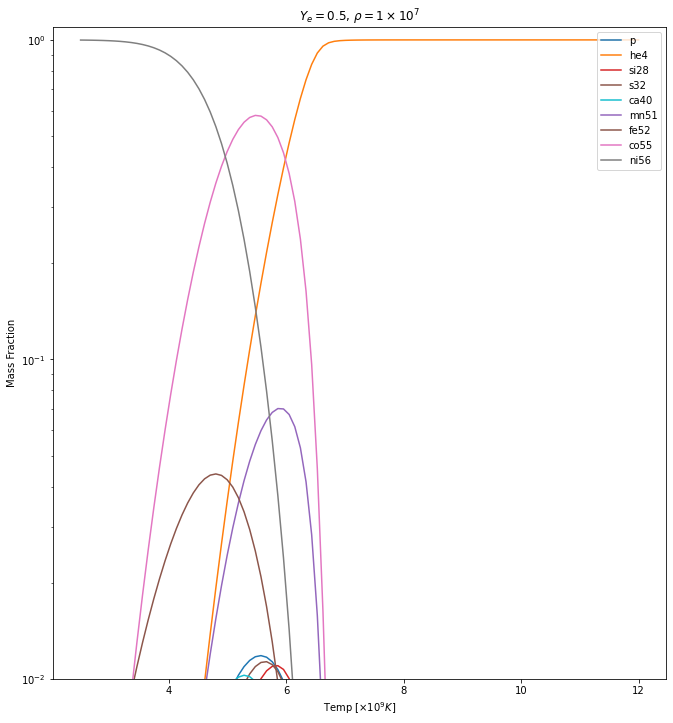

In [5]:
X_s = np.array(X_s)
nuc_names = rc.get_nuclei()

low_limit = 1e-2
fig = plt.figure(figsize=(11,12))
ax = fig.add_subplot(111)
for k in range(len(nuc_names)):
    line, = ax.plot(temps, X_s[:,k])
    if (max(X_s[:,k]) > low_limit):
        line.set_label(str(nuc_names[k]))

ax.legend(loc = "upper right")
ax.set_xlabel(r'Temp $[\times 10^9 K]$')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([low_limit,1.1])
ax.set_title(r"$Y_e = 0.5$, $\rho = 1 \times 10^7$")


For $\rho = 1\times 10^7 [g/cm^{3}]$ and a relatively high temperature of $ T = 6 \times 10^9 [K]$

In [6]:
ye_low = min(nuc.Z/nuc.A for nuc in rc.unique_nuclei)
rho = 1e7
ye_s = np.linspace(ye_low, 0.65, 100)
temp = 6.0e9
X_s_1 = []

guess = [-6.0, -11.5]
for i, ye in enumerate(ye_s):
    nse_comp_1, sol = rc.get_comp_nse(rho, temp, ye, init_guess=guess, 
                                      use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s_1 = [nse_comp_1.X[nuc] for nuc in nse_comp_1.X]
    X_s_1.append(nse_X_s_1)

Text(0.5, 1.0, '$\\rho = 1 \\times 10^7$ and $T=6 \\times 10^9$')

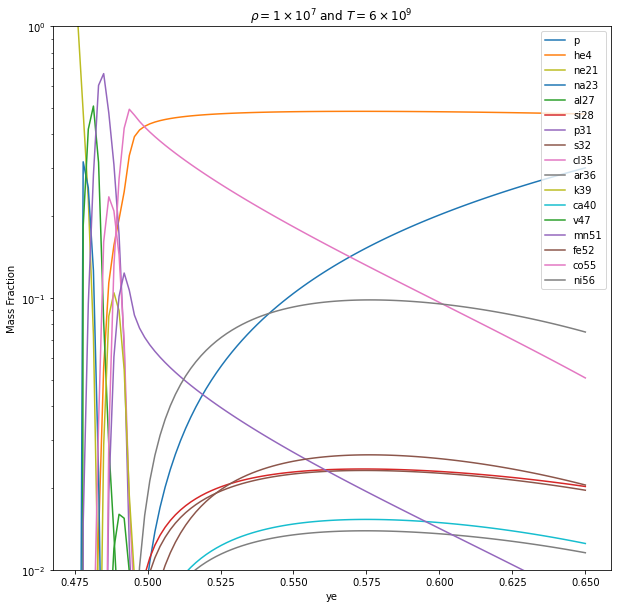

In [7]:
X_s_1 = np.array(X_s_1)
nuc_names = rc.get_nuclei()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for k in range(len(nuc_names)):
    line, = ax.plot(ye_s, X_s_1[:,k])
    if (max(X_s_1[:,k]) > 0.01):
        line.set_label(str(nuc_names[k]))
ax.legend(loc = "best")
ax.set_xlabel('ye')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([0.01,1])
ax.set_title(r"$\rho = 1 \times 10^7$ and $T=6 \times 10^9$")